In [53]:
import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

In [54]:
train_data=datasets.MNIST(root='data',
                          train=True,
                          download=True,
                          transform=ToTensor(),
                          target_transform=None)

In [55]:
img,label=train_data[0]

In [56]:
img.shape,train_data.classes

(torch.Size([1, 28, 28]),
 ['0 - zero',
  '1 - one',
  '2 - two',
  '3 - three',
  '4 - four',
  '5 - five',
  '6 - six',
  '7 - seven',
  '8 - eight',
  '9 - nine'])

Image Shape:torch.Size([1, 28, 28])


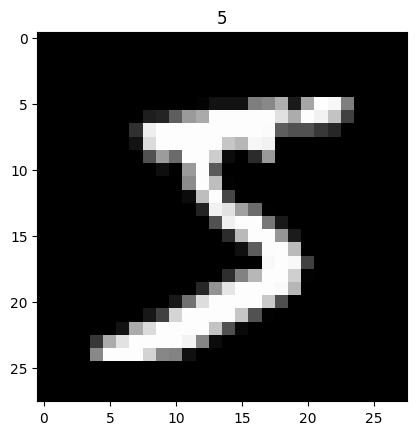

In [57]:
#Visualizing
img,label=train_data[0]
print(f"Image Shape:{img.shape}")
plt.imshow(img.squeeze(),cmap='gray')
plt.title(label);

Image Shape:torch.Size([1, 28, 28])


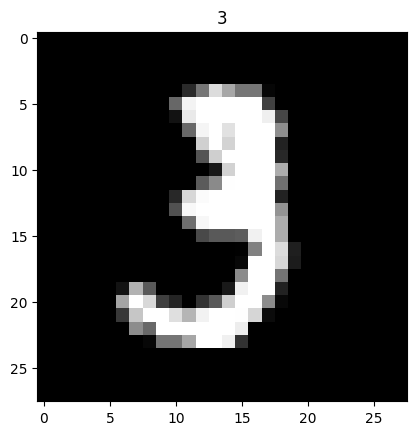

In [58]:
img,label=train_data[10]
print(f"Image Shape:{img.shape}")
plt.imshow(img.squeeze(),cmap='gray')
plt.title(label);

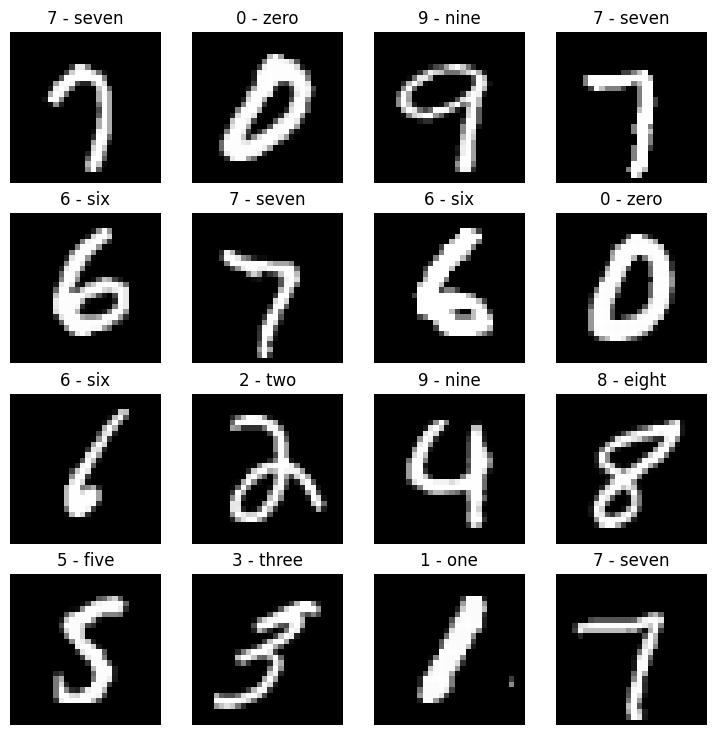

In [59]:
#Plotting Batch of Images
torch.manual_seed(1)
fig=plt.figure(figsize=(9,9))
rows,cols=4,4

for i in range(1,rows*cols+1):
  random_idx=torch.randint(0,len(train_data),size=[1]).item()
  img,label=train_data[random_idx]
  fig.add_subplot(rows,cols,i)
  plt.imshow(img.squeeze(),cmap='gray')
  plt.axis(False)
  plt.title(train_data.classes[label]);

In [60]:
#Device Code
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [61]:
#Preparing DataLoader
from torch.utils.data import DataLoader
BATCH_SIZE=32

data_loader=DataLoader(train_data,
                       batch_size=BATCH_SIZE,
                       shuffle=True)

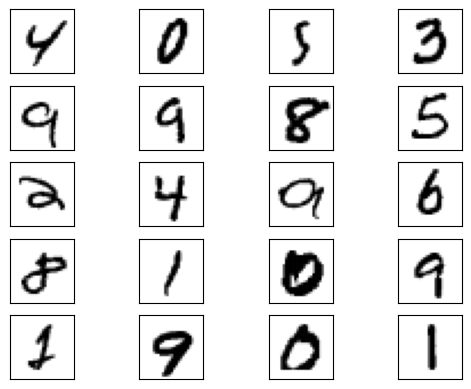

In [62]:
img,label=next(iter(data_loader))
for i in range(20):
  ax=plt.subplot(5,4,i+1)
  plt.imshow(img[i].reshape(28,28),cmap='gray_r')
  plt.xticks([])
  plt.yticks([])

In [63]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.model=nn.Sequential(
        nn.Linear(784,1024),
        nn.LeakyReLU(),
        nn.Linear(1024,500),
        nn.LeakyReLU(),
        nn.Linear(500,250),
        nn.LeakyReLU(),
        nn.Linear(250,1),
        nn.Sigmoid()
    )

  def forward(self,x):
      x=x.view(x.size(0),784)
      output=self.model(x)
      return output

In [64]:
discriminator=Discriminator().to(device)

In [65]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.model=nn.Sequential(
        nn.Linear(100,256),
        nn.ReLU(),
        nn.Linear(256,512),
        nn.ReLU(),
        nn.Linear(512,784),
        nn.ReLU(),
        nn.Linear(784,1024),
        nn.Linear(1024,784),
        nn.Tanh(),
    )

  def forward(self,x):
      output=self.model(x)
      output=output.view(x.size(0),1,28,28)
      return output


In [66]:
generator=Generator().to(device)

In [67]:
loss_fn=nn.BCELoss()
optimizer_discriminator=torch.optim.SGD(params=discriminator.parameters(),lr=0.01)
optimizer_generator=torch.optim.SGD(params=generator.parameters(),lr=0.01)

In [68]:
torch.manual_seed(42)
epochs=10
batch_size=32
for epoch in range(epochs):
    for n, (real_samples, mnist_labels) in enumerate(data_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_fn(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_fn(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.6835616827011108
Epoch: 0 Loss G.: 0.6786187887191772
Epoch: 1 Loss D.: 0.24317088723182678
Epoch: 1 Loss G.: 2.3273561000823975
Epoch: 2 Loss D.: 0.23865212500095367
Epoch: 2 Loss G.: 2.212982177734375
Epoch: 3 Loss D.: 0.20325741171836853
Epoch: 3 Loss G.: 2.8875744342803955
Epoch: 4 Loss D.: 0.2293444722890854
Epoch: 4 Loss G.: 2.341261625289917
Epoch: 5 Loss D.: 0.14875516295433044
Epoch: 5 Loss G.: 2.7104244232177734
Epoch: 6 Loss D.: 0.37449413537979126
Epoch: 6 Loss G.: 3.3969593048095703
Epoch: 7 Loss D.: 0.16818776726722717
Epoch: 7 Loss G.: 2.591002941131592
Epoch: 8 Loss D.: 0.21813134849071503
Epoch: 8 Loss G.: 3.0858781337738037
Epoch: 9 Loss D.: 0.29484236240386963
Epoch: 9 Loss G.: 2.200155735015869


In [69]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

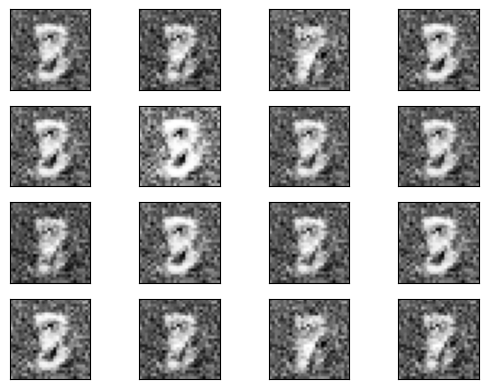

In [70]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray")
    plt.xticks([])
    plt.yticks([])